In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from adapters import *
from dataset import NumpyCsvDataSet
from runner import ExptRunner
from networks.autoencoder import AutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.lossfunctions import *

In [4]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [5]:
data_folder = 'data/demoplanner/version2'
train_data = NumpyCsvDataSet(data_folder + '/train.csv')
test_data = NumpyCsvDataSet(data_folder + '/test.csv')
# training_loader = DataLoader(train_data, batch_size=50, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=3, shuffle=True)

In [6]:
print (train_data.data.shape)
print (test_data.data.shape)

torch.Size([129779, 2058])
torch.Size([6648, 2058])


In [ ]:
# %reset -f ComposedAutoEncoder
# %reset -f VAE
# from networks.composedautoencoder import ComposedAutoEncoder
# from networks.vae import VAE

In [8]:
expts = [
    ['DemoPl-V2-ComposedAutoEncoderNoMaxPool-MSE-', ComposedAutoEncoder, demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ComposedAutoEncoderNoMaxPool-SmoothL1-', ComposedAutoEncoder, demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ComposedAutoEncoderWithMaxPool-MSE-', lambda: ComposedAutoEncoder(useMaxPool=True), demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-', lambda: ComposedAutoEncoder(useMaxPool=True), demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-DenseAutoEncoder3-MSE-', lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]), demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-DenseAutoEncoder3-SmoothL1-', lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]), demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-VAE-VAELoss-', VAE, demopl_v1_data_adapter, vae_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ConvVAE-VAELoss-', ConvVae, demopl_v1_data_adapter, vae_loss_adapter, demopl_v1_data_to_img],
]

Log folder for expt 0: runs/03-18-11-30-35-DemoPl-V2-ComposedAutoEncoderNoMaxPool-MSE-
Reconstruction At Index 999


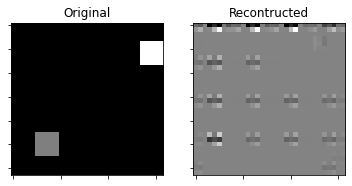

Reconstruction At Index 1999


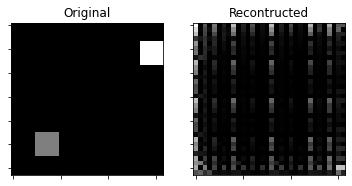

Reconstruction At Index 3595


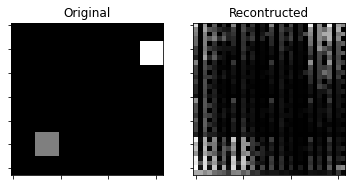

Reconstruction At Index 4595


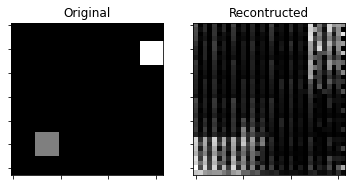

Final Reconstruction


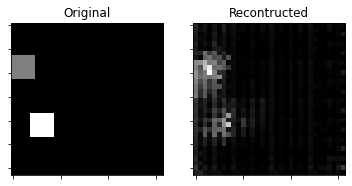

In [17]:
train_epochs = 2
for i in range(len(expts)):
    inputs = expts[i]
    runner = ExptRunner(inputs[0], inputs[1](), train_data, test_data, inputs[2], inputs[3], data_to_img_func=inputs[4])
    print ("Log folder for expt {}: {}".format(i, runner.log_folder))
    runner.train(train_epochs, shouldShowReconstruction=True)
    runner.test()

In [ ]:
np.set_printoptions(**opt)